# Projet de Reinforcement Learning - Dash Game Agent

authors : nathan.claude / abel.aubron

## Introduction

Ce projet implémente plusieurs agents de **Reinforcement Learning** pour jouer automatiquement au jeu **Dash**, un clone simplifié de Geometry Dash. L'objectif est de comparer les performances de différentes approches :

1. **Agent basé sur les valeurs (Value-Based)** : Deep Q-Network (DQN) avec Experience Replay et Target Network
2. **Agent basé sur Policy Gradient** : REINFORCE avec baseline

Le projet inclut également une **analyse comparative** des performances et une **étude de sensibilité** aux hyperparamètres.

### Structure du projet

```
├── Dash_Game/           # Environnement de jeu
│   ├── src/
│   │   ├── game_env.py  # Environnement RL compatible Gym
│   │   ├── physics.py   # Moteur physique
│   │   └── ...
│   └── layouts/         # Niveaux du jeu (.csv)
└── Rl_agents/           # Agents RL
    ├── agents.py        # Implémentation des agents
    ├── main.py          # Script d'entraînement
    └── visualizer.py    # Outils de visualisation
```

---

## 1. Définition de l'environnement - Processus de Décision de Markov (MDP)

### 1.1 Description du jeu Dash

Le jeu **Dash** est un platformer à défilement horizontal où le joueur contrôle un cube qui avance automatiquement. L'objectif est d'éviter les obstacles (spikes) et d'utiliser les orbes pour naviguer dans le niveau.

### 1.2 Formalisation MDP

Un **Processus de Décision de Markov** est défini par le tuple $(S, A, P, R, \gamma)$ :

#### Espace des États $S$

L'état est un vecteur de **95 dimensions** contenant :

| Composante | Dimension | Description |
|------------|-----------|-------------|
| Position Y du joueur | 1 | Normalisée par la hauteur max |
| Vélocité verticale | 1 | Normalisée par la vitesse max |
| Au sol (grounded) | 1 | Booléen (0 ou 1) |
| Gravité inversée | 1 | Booléen (0 ou 1) |
| Progression | 1 | Pourcentage du niveau parcouru |
| Objets proches | 90 | 30 objets × 3 features (type, rel_x, rel_y) |

$$\mathbf{s}_t = [y, v_y, \text{grounded}, \text{reversed}, \text{progress}, o_1, ..., o_{30}]$$

#### Espace des Actions $A$

L'espace d'actions est **discret** avec 2 actions possibles :

$$A = \{0: \text{ne pas sauter}, 1: \text{sauter}\}$$

#### Fonction de Transition $P(s' | s, a)$

La transition est **déterministe** (pas de stochasticité) et définie par le moteur physique :
- Gravité appliquée à chaque frame
- Collision avec les obstacles (mort instantanée)
- Interaction avec les orbes (changement de vélocité/gravité)

#### Fonction de Récompense $R(s, a, s')$

Le **reward shaping** est crucial pour guider l'apprentissage :

$$R(s, a, s') = \begin{cases}
+1.0 & \text{si victoire (fin du niveau)} \\
-1.0 & \text{si mort (collision avec spike)} \\
+0.01 & \text{récompense de survie par frame} \\
-0.005 & \text{pénalité pour saut inutile (au sol)}
\end{cases}$$

#### Facteur de Discount $\gamma$

$$\gamma = 0.99$$

Un gamma élevé encourage l'agent à planifier sur le long terme, essentiel pour un jeu où les récompenses majeures arrivent à la fin.

In [1]:
# =============================================================================
# Configuration et Imports
# =============================================================================
# Ce bloc initialise toutes les dépendances nécessaires pour le projet

import sys
import os
import time
import copy
import pickle
import random
from typing import List, Tuple, Dict, Optional
from collections import deque

# Bibliothèques scientifiques
import numpy as np
import matplotlib.pyplot as plt

# PyTorch pour les réseaux de neurones
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# Ajouter les chemins du projet au PYTHONPATH
project_root = os.path.dirname(os.path.abspath("__file__"))
sys.path.insert(0, os.path.join(project_root, 'Dash_Game'))
sys.path.insert(0, os.path.join(project_root, 'Rl_agents'))

# Détection du device (GPU/CPU/MPS pour Mac M1/M2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")

print(f"Device utilisé: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Python version: {sys.version.split()[0]}")

Device utilisé: cuda
PyTorch version: 2.3.1+cu118
Python version: 3.10.11


In [2]:
# =============================================================================
# Environnement de jeu - DashGameEnv
# =============================================================================
# Implémentation de l'environnement compatible avec l'interface Gym/Gymnasium

# Changer de répertoire pour charger les assets du jeu
original_dir = os.getcwd()
dash_game_dir = os.path.join(project_root, 'Dash_Game')
os.chdir(dash_game_dir)

# Import des modules du jeu
from src.layout import DashLayout, DashObject, DashObjectType
from src.layout_reader import DashLayoutReader
from src.velocity import DashVelocity
from dataclasses import dataclass

@dataclass
class ObjectInfo:
    """Information sur un objet proche du joueur"""
    object_type: int   # ID du type d'objet (1-11)
    relative_x: float  # Position X relative au joueur
    relative_y: float  # Position Y relative au joueur
    absolute_x: float  # Position X absolue
    absolute_y: float  # Position Y absolue


@dataclass
class GameState:
    """État complet du jeu pour l'agent RL"""
    player_x: float
    player_y: float
    player_velocity: float
    reversed_gravity: bool
    is_grounded: bool
    nearby_objects: List[ObjectInfo]
    progress: float  # Progression dans le niveau (0-1)
    

@dataclass 
class ReplayFrame:
    """Frame pour le système de replay - permet de visualiser les parties"""
    player_position: Tuple[float, float]
    player_velocity: float
    reversed_gravity: bool
    line: float
    action: int  # 0: no jump, 1: jump
    progress: float
    objects_snapshot: List[Tuple[int, float, float]]


class DashPhysicsHeadless:
    """
    Moteur physique sans rendu graphique pour l'entraînement rapide.
    
    Ce moteur simule:
    - La gravité et les collisions
    - Les interactions avec les orbes (changement de gravité, boost)
    - La détection de mort (spikes) ou victoire
    """
    
    # Constantes physiques du jeu
    GRAVITY = 1
    MAX_SPEED = 2
    GAME_SPEED = 2
    
    # Tailles des hitboxes pour la détection de collision
    HITBOX_SPIKE = 0.7
    HITBOX_ORB = 0.75
    
    HITBOX_SIZE = {
        DashObjectType.BLOCK: 1,
        DashObjectType.UP_SPIKE: HITBOX_SPIKE,
        DashObjectType.RIGHT_SPIKE: HITBOX_SPIKE,
        DashObjectType.DOWN_SPIKE: HITBOX_SPIKE,
        DashObjectType.LEFT_SPIKE: HITBOX_SPIKE,
        DashObjectType.YELLOW_ORB: HITBOX_ORB,
        DashObjectType.PINK_ORB: HITBOX_ORB,
        DashObjectType.BLUE_ORB: HITBOX_ORB,
        DashObjectType.GREEN_ORB: HITBOX_ORB,
        DashObjectType.RED_ORB: HITBOX_ORB,
        DashObjectType.BLACK_ORB: HITBOX_ORB
    }
    
    # Forces de saut pour chaque type d'orbe
    REBOUND_FRAMES = 20
    JUMP_FORCE = 0.22
    YELLOW_ORB_FORCE = 0.25
    PINK_ORB_FORCE = 0.2
    BLUE_ORB_FORCE = 0.25
    GREEN_ORB_FORCE = 0.25
    RED_ORB_FORCE = 0.32
    BLACK_ORB_FORCE = 0.4
    
    def __init__(self, layout: DashLayout) -> None:
        self.layout = layout
        self.cube_position = (7.5, 0)
        self.cube_velocity = DashVelocity()
        self.line = -10
        self.progress = 0.0
        self.died = False
        self.won = False
        self.rebound = 0
        self.falling = False
        self.just_jump_frames = 0
        
        # Calculer la fin du niveau basée sur le dernier objet
        if len(layout.objects) > 0:
            self.level_end_x = max(obj.position[0] for obj in layout.objects)
        else:
            self.level_end_x = 100.0
        
        self.start_x = self.cube_position[0] + self.line
        
    def is_cube_touching(self, obj: DashObject) -> bool:
        """Vérifie si le cube touche un objet"""
        touch_distance = self.HITBOX_SIZE[obj.objectType]
        real_dist_x = abs(self.cube_position[0] + self.line - obj.position[0])
        real_dist_y = abs(self.cube_position[1] - obj.position[1])
        return real_dist_x < touch_distance and real_dist_y < touch_distance
    
    def is_cube_grounded(self, obj: DashObject) -> bool:
        """Vérifie si le cube est posé sur un bloc"""
        if obj.objectType != DashObjectType.BLOCK:
            return False
        grounded_distance = 1.01
        threshold = 0.4
        lower_bound = grounded_distance - threshold
        above = (self.cube_position[1] > obj.position[1]) ^ self.cube_velocity.reversed_gravity
        real_dist_x = abs(self.cube_position[0] + self.line - obj.position[0])
        real_dist_y = abs(self.cube_position[1] - obj.position[1])
        return above and real_dist_x < grounded_distance and lower_bound < real_dist_y <= grounded_distance
    
    def get_nearby_objects(self, range_ahead: float = 6.0, range_behind: float = 1.5, 
                           range_vertical: float = 6.0) -> List[ObjectInfo]:
        """
        Récupère les objets proches du joueur dans une zone de détection.
        
        Args:
            range_ahead: Distance de détection devant le joueur
            range_behind: Distance de détection derrière le joueur  
            range_vertical: Distance de détection verticale
        """
        nearby = []
        player_world_x = self.cube_position[0] + self.line
        player_y = self.cube_position[1]

        for obj in self.layout.objects:
            obj_x, obj_y = obj.position
            rel_x = obj_x - player_world_x
            rel_y = obj_y - player_y

            if -range_behind <= rel_x <= range_ahead and abs(rel_y) <= range_vertical:
                nearby.append(ObjectInfo(
                    object_type=obj.objectType.value,
                    relative_x=rel_x,
                    relative_y=rel_y,
                    absolute_x=obj_x,
                    absolute_y=obj_y
                ))

        nearby.sort(key=lambda o: o.relative_x)
        return nearby
    
    def get_game_state(self) -> GameState:
        """Retourne l'état complet du jeu pour l'agent RL"""
        nearby = self.get_nearby_objects()
        player_world_x = self.cube_position[0] + self.line
        
        # Calcul de la progression
        total_distance = self.level_end_x - self.start_x
        if total_distance > 0:
            current_distance = player_world_x - self.start_x
            self.progress = max(0.0, min(1.0, current_distance / total_distance))
        else:
            self.progress = 1.0 if self.won else 0.0
        
        return GameState(
            player_x=player_world_x,
            player_y=self.cube_position[1],
            player_velocity=self.cube_velocity.velocity,
            reversed_gravity=self.cube_velocity.reversed_gravity,
            is_grounded=not self.falling,
            nearby_objects=nearby,
            progress=self.progress
        )
    
    def step(self, jump: bool, just_jump: bool = False) -> Tuple[bool, bool]:
        """
        Exécute un pas de simulation physique.
        
        Args:
            jump: True si l'agent veut sauter
            just_jump: True si c'est le début d'un saut (pour les orbes)
            
        Returns:
            (died, won): Tuple indiquant si le joueur est mort ou a gagné
        """
        if self.died or self.won:
            return self.died, self.won
            
        # Vérifier victoire
        if len(self.layout.objects) == 0 or \
           (len(self.layout.objects) > 0 and self.layout.objects[-1].position[0] - self.line <= 0):
            self.won = True
            return False, True
        
        # Vérifier limites
        if self.cube_position[1] > 20 or (self.cube_position[1] <= 0 and self.cube_velocity.reversed_gravity):
            self.died = True
            return True, False
        
        # Nettoyer les objets passés
        while self.layout.should_remove_leftmost_object(self.line):
            self.layout.remove_leftmost_object()
        
        self.falling = self.cube_position[1] != 0 or self.cube_velocity.reversed_gravity
        
        # Mise à jour position
        new_y = max(0, self.cube_position[1] + self.cube_velocity.velocity)
        self.cube_position = (self.cube_position[0], new_y)
        
        # Gestion just_jump
        if jump and self.just_jump_frames <= 0:
            self.just_jump_frames = 20
        self.just_jump_frames -= 1
        actual_just_jump = just_jump or self.just_jump_frames > 0
        
        # Collisions et interactions avec les objets
        for obj in self.layout.objects:
            if not DashLayout.should_display_object(obj, self.line):
                break
            
            # Spikes = mort
            if obj.objectType in [DashObjectType.UP_SPIKE, DashObjectType.RIGHT_SPIKE, 
                                   DashObjectType.DOWN_SPIKE, DashObjectType.LEFT_SPIKE]:
                if self.is_cube_touching(obj):
                    self.died = True
                    return True, False
                    
            # Blocs = plateforme ou collision
            elif obj.objectType == DashObjectType.BLOCK:
                if self.is_cube_grounded(obj):
                    self.falling = False
                    self.cube_velocity.set_speed(0)
                    unit = -1 if self.cube_velocity.reversed_gravity else 1
                    self.cube_position = (self.cube_position[0], obj.position[1] + unit)
                    self.rebound = 0
                elif self.is_cube_touching(obj):
                    self.died = True
                    return True, False
                    
            # Orbes = effets spéciaux si saut actif
            elif self.rebound == 0 and actual_just_jump and self.is_cube_touching(obj):
                if obj.objectType == DashObjectType.YELLOW_ORB:
                    self.cube_velocity.set_speed(self.YELLOW_ORB_FORCE)
                    self.rebound = self.REBOUND_FRAMES
                elif obj.objectType == DashObjectType.PINK_ORB:
                    self.cube_velocity.set_speed(self.PINK_ORB_FORCE)
                    self.rebound = self.REBOUND_FRAMES
                elif obj.objectType == DashObjectType.BLUE_ORB:
                    self.cube_velocity.reverse_gravity()
                    self.rebound = self.REBOUND_FRAMES
                elif obj.objectType == DashObjectType.GREEN_ORB:
                    self.cube_velocity.reverse_gravity()
                    self.cube_velocity.set_speed(self.GREEN_ORB_FORCE)
                    self.rebound = self.REBOUND_FRAMES
                elif obj.objectType == DashObjectType.RED_ORB:
                    self.cube_velocity.set_speed(self.RED_ORB_FORCE)
                    self.rebound = self.REBOUND_FRAMES
                elif obj.objectType == DashObjectType.BLACK_ORB:
                    self.cube_velocity.set_speed(-self.BLACK_ORB_FORCE)
                    self.rebound = self.REBOUND_FRAMES
        
        # Appliquer gravité
        if self.falling:
            self.cube_velocity.fall()
        
        # Saut normal
        if jump and not self.falling and self.rebound == 0:
            self.cube_velocity.set_speed(0.22)
            self.rebound = self.REBOUND_FRAMES
        elif self.rebound > 0:
            self.rebound -= 1
        
        # Avancer dans le niveau
        self.line += 0.09173
        
        return False, False


class DashGameEnv:
    """
    Environnement de jeu compatible avec l'interface Gymnasium/OpenAI Gym.
    
    Cette classe encapsule la logique du jeu pour permettre l'entraînement
    d'agents RL avec l'API standard step(action) -> (obs, reward, done, info)
    """
    
    MAX_NEARBY_OBJECTS = 30  # Nombre max d'objets dans l'observation
    ACTION_NONE = 0
    ACTION_JUMP = 1
    
    def __init__(self, level_path: str = "layouts/level1.csv", 
                 record_replay: bool = False,
                 max_steps: int = 10000):
        """
        Args:
            level_path: Chemin vers le fichier CSV du niveau
            record_replay: Si True, enregistre les frames pour replay
            max_steps: Nombre maximum de steps avant timeout
        """
        self.level_path = level_path
        self.record_replay = record_replay
        self.max_steps = max_steps
        
        self.original_layout = DashLayoutReader.read_layout_from_csv(level_path)
        
        self.physics: Optional[DashPhysicsHeadless] = None
        self.current_step = 0
        self.replay_frames: List[ReplayFrame] = []
        
        self.total_episodes = 0
        self.total_wins = 0
        
        # Taille de l'observation: 5 features joueur + 30 objets * 3 features
        self.observation_size = 5 + self.MAX_NEARBY_OBJECTS * 3
        
        self.reset()
    
    def _copy_layout(self) -> DashLayout:
        """Crée une copie du layout pour pouvoir le réinitialiser"""
        original_objects = list(self.original_layout.objects)
        new_objects = [DashObject(obj.objectType, obj.position) for obj in original_objects]
        return DashLayout(new_objects)
    
    def reset(self) -> np.ndarray:
        """Reset l'environnement et retourne l'observation initiale"""
        layout = self._copy_layout()
        self.physics = DashPhysicsHeadless(layout)
        self.current_step = 0
        self.replay_frames = []
        self.total_episodes += 1
        return self._get_observation()
    
    def _get_observation(self) -> np.ndarray:
        """
        Convertit l'état du jeu en vecteur d'observation normalisé.
        
        Structure du vecteur (95 dimensions):
        [0]: Position Y normalisée
        [1]: Vélocité normalisée  
        [2]: Au sol (0/1)
        [3]: Gravité inversée (0/1)
        [4]: Progression (0-1)
        [5:95]: 30 objets × (type, rel_x, rel_y)
        """
        state = self.physics.get_game_state()
        obs = np.zeros(self.observation_size, dtype=np.float32)

        # État du joueur (normalisé)
        obs[0] = state.player_y / 12.0
        obs[1] = state.player_velocity / 0.4
        obs[2] = 1.0 if state.is_grounded else 0.0
        obs[3] = 1.0 if state.reversed_gravity else 0.0
        obs[4] = state.progress

        # Objets proches (normalisés)
        for i, obj in enumerate(state.nearby_objects[:self.MAX_NEARBY_OBJECTS]):
            base_idx = 5 + i * 3
            obs[base_idx] = obj.object_type / 11.0     # 11 types d'objets
            obs[base_idx + 1] = obj.relative_x / 9.0   # Distance ahead
            obs[base_idx + 2] = obj.relative_y / 6.0   # Distance verticale

        return obs
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, Dict]:
        """
        Exécute une action et retourne le résultat.
        
        Args:
            action: 0 = ne pas sauter, 1 = sauter
            
        Returns:
            observation: Vecteur d'observation (95 dim)
            reward: Récompense [-1, 1]
            done: True si épisode terminé
            info: Dictionnaire avec informations supplémentaires
        """
        jump = action == self.ACTION_JUMP
        
        # Enregistrement pour replay
        if self.record_replay:
            objects_snapshot = [(obj.object_type, obj.relative_x, obj.relative_y) 
                               for obj in self.physics.get_nearby_objects()[:10]]
            self.replay_frames.append(ReplayFrame(
                player_position=self.physics.cube_position,
                player_velocity=self.physics.cube_velocity.velocity,
                reversed_gravity=self.physics.cube_velocity.reversed_gravity,
                line=self.physics.line,
                action=action,
                progress=self.physics.progress,
                objects_snapshot=objects_snapshot
            ))
        
        # Simulation physique
        died, won = self.physics.step(jump)
        self.current_step += 1
        
        # Calcul de la récompense avec reward shaping
        reward = self._calculate_reward(died, won, jump)
        
        # Clipping de la récompense pour stabilité
        reward = max(min(reward, 1.0), -1.0)
        
        done = died or won or self.current_step >= self.max_steps
        
        info = {
            'died': died,
            'won': won,
            'progress': self.physics.progress,
            'steps': self.current_step,
            'player_y': self.physics.cube_position[1]
        }
        
        if won:
            self.total_wins += 1
        
        return self._get_observation(), reward, done, info
    
    def _calculate_reward(self, died: bool, won: bool, jumped: bool) -> float:
        """
        Reward Shaping - Conception de la fonction de récompense.
        
        Principes appliqués:
        - Récompense sparse pour victoire/mort
        - Dense reward pour encourager la survie
        - Pénalité légère pour sauts inutiles (éviter le spam)
        """
        if won:
            return 1.0   # Victoire = récompense maximale
        if died:
            return -1.0  # Mort = pénalité maximale
        
        reward = 0.01    # Récompense de survie
        
        # Pénalité pour saut au sol (encourage sauts précis)
        if jumped and not self.physics.falling:
            reward -= 0.005
            
        return reward
    
    def get_replay(self) -> List[ReplayFrame]:
        """Retourne les frames enregistrées pour le replay"""
        return self.replay_frames

# Test de l'environnement
env = DashGameEnv("layouts/level1.csv", record_replay=False, max_steps=5000)
print(f"Environnement créé avec succès!")
print(f"Taille de l'observation: {env.observation_size} dimensions")
print(f"Actions possibles: {['Ne pas sauter', 'Sauter']}")

# Test d'un épisode avec actions aléatoires
obs = env.reset()
done = False
total_reward = 0
steps = 0

while not done:
    action = random.randint(0, 1)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    steps += 1

print(f"\nTest avec agent aléatoire:")
print(f"   Steps: {steps}")
print(f"   Progression: {info['progress']*100:.1f}%")
print(f"   Récompense totale: {total_reward:.2f}")
print(f"   Résultat: {'🏆 Victoire!' if info['won'] else '💀 Mort'}")

Environnement créé avec succès!
Taille de l'observation: 95 dimensions
Actions possibles: ['Ne pas sauter', 'Sauter']

Test avec agent aléatoire:
   Steps: 185
   Progression: 7.9%
   Récompense totale: 0.82
   Résultat: 💀 Mort


### 1.4 Lancer le jeu manuellement

Vous pouvez jouer au jeu vous-même pour mieux comprendre le défi ! Le jeu comporte plusieurs éléments :

| Élément | Description |
|---------|-------------|
| **Blocs** | Obstacles solides sur lesquels le joueur peut se poser |
| **Spikes** | Pièges mortels (4 rotations possibles) |
| **Yellow Orb** 🟡 | Saut normal |
| **Pink Orb** 🩷 | Petit saut |
| **Blue Orb** 🔵 | Inverse la gravité |
| **Green Orb** 🟢 | Inverse la gravité puis saute |
| **Red Orb** 🔴 | Grand saut |
| **Black Orb** ⚫ | Pousse vers la gravité |

**Contrôles** : `ESPACE` ou `CLIC` pour sauter, `ESC` pour quitter.

**Pour lancer le jeu**, exécutez dans un terminal :
```bash
cd Dash_Game
python main.py
```

---

## 2. Agent basé sur les Valeurs - Deep Q-Network (DQN)

### 2.1 Principe théorique

L'algorithme **DQN** (Deep Q-Network) apprend une fonction $Q(s, a)$ qui estime la valeur espérée des récompenses futures en prenant l'action $a$ dans l'état $s$ :

$$Q(s, a) = \mathbb{E}\left[\sum_{t=0}^{\infty} \gamma^t r_t \mid s_0 = s, a_0 = a\right]$$

L'objectif est de minimiser l'erreur de Bellman (TD Error) :

$$\mathcal{L}(\theta) = \mathbb{E}_{(s,a,r,s') \sim \mathcal{D}}\left[\left(r + \gamma \max_{a'} Q_{\theta^-}(s', a') - Q_\theta(s, a)\right)^2\right]$$

### 2.2 Améliorations implémentées

Notre implémentation inclut plusieurs améliorations classiques :

| Technique | Description | Bénéfice |
|-----------|-------------|----------|
| **Experience Replay** | Buffer de transitions échantillonnées aléatoirement | Casse les corrélations temporelles |
| **Target Network** | Réseau cible mis à jour périodiquement | Stabilise l'apprentissage |
| **ε-greedy decay** | Exploration décroissante exponentiellement | Balance exploration/exploitation |
| **Gradient Clipping** | Limite la norme des gradients | Évite l'explosion des gradients |

### 2.3 Architecture du réseau

```
Input (95) → Linear(256) → ReLU → Linear(128) → ReLU → Linear(2)
```

In [3]:
# =============================================================================
# Agent DQN - Deep Q-Network
# =============================================================================
# Implémentation d'un agent DQN avec Experience Replay et Target Network

class DQN(nn.Module):
    """
    Réseau de neurones pour approximer la fonction Q(s, a).
    
    Architecture configurable avec couches cachées dynamiques.
    Utilise ReLU comme fonction d'activation (standard pour DQN).
    """
    
    def __init__(self, input_dim: int, output_dim: int, hidden_sizes: List[int]):
        """
        Args:
            input_dim: Dimension de l'état d'entrée (95 pour notre env)
            output_dim: Nombre d'actions (2: jump/no-jump)
            hidden_sizes: Liste des tailles des couches cachées
        """
        super(DQN, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Construction dynamique des couches cachées
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_dim, hidden_size))
            layers.append(nn.ReLU())  # ReLU pour la non-linéarité
            prev_dim = hidden_size
            
        # Couche de sortie (pas d'activation - valeurs Q brutes)
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass du réseau.
        
        Args:
            x: Tensor d'état de shape (batch_size, input_dim)
            
        Returns:
            Q-values pour chaque action, shape (batch_size, output_dim)
        """
        return self.network(x)


class DQNAgent:
    """
    Agent DQN complet avec toutes les améliorations modernes.
    
    Caractéristiques:
    - Experience Replay Buffer pour décorréler les échantillons
    - Target Network pour stabiliser les cibles Q
    - Epsilon-greedy avec décroissance pour l'exploration
    - Gradient clipping pour la stabilité
    """
    
    def __init__(self, 
                 state_size: int = 95, 
                 action_size: int = 2,
                 hidden_sizes: List[int] = [256, 128],
                 learning_rate: float = 0.0005,
                 gamma: float = 0.99,
                 epsilon_start: float = 1.0,
                 epsilon_end: float = 0.01,
                 epsilon_decay: float = 0.995,
                 batch_size: int = 64,
                 buffer_capacity: int = 50000,
                 target_update_freq: int = 500):
        """
        Args:
            state_size: Dimension du vecteur d'état
            action_size: Nombre d'actions possibles
            hidden_sizes: Architecture du réseau [couche1, couche2, ...]
            learning_rate: Taux d'apprentissage pour Adam
            gamma: Facteur de discount (γ)
            epsilon_start: Valeur initiale d'epsilon (exploration)
            epsilon_end: Valeur minimale d'epsilon
            epsilon_decay: Facteur de décroissance multiplicatif
            batch_size: Taille des mini-batches
            buffer_capacity: Taille max du replay buffer
            target_update_freq: Fréquence de sync du target network
        """
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        # Réseaux: Policy (entraîné) et Target (cible stable)
        self.policy_net = DQN(state_size, action_size, hidden_sizes).to(device)
        self.target_net = DQN(state_size, action_size, hidden_sizes).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Le target net n'est jamais entraîné directement
        
        # Optimiseur Adam (standard pour DQN)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
        # Loss MSE (ou Huber/SmoothL1 pour plus de robustesse)
        self.criterion = nn.MSELoss()
        
        # Replay Buffer (deque pour efficacité FIFO)
        self.memory = deque(maxlen=buffer_capacity)
        self.training_steps = 0

    def select_action(self, state: np.ndarray, training: bool = True) -> int:
        """
        Sélection d'action avec politique ε-greedy.
        
        En mode training: explore avec probabilité ε
        En mode eval: toujours greedy (meilleure action)
        
        Args:
            state: Vecteur d'état actuel
            training: Si True, utilise ε-greedy
            
        Returns:
            Action sélectionnée (0 ou 1)
        """
        # Exploration aléatoire
        if training and random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        
        # Exploitation: choisir l'action avec la Q-value max
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.policy_net(state_tensor)
            return q_values.argmax().item()

    def update(self, state: np.ndarray, action: int, reward: float, 
               next_state: np.ndarray, done: bool):
        """
        Stocke une transition et effectue un pas d'apprentissage.
        
        Implémente l'algorithme DQN standard:
        1. Stocker (s, a, r, s', done) dans le buffer
        2. Échantillonner un mini-batch aléatoire
        3. Calculer les cibles Q avec le target network
        4. Mettre à jour le policy network par gradient descent
        5. Décroître epsilon
        
        Args:
            state: État initial
            action: Action effectuée
            reward: Récompense reçue
            next_state: État suivant
            done: True si épisode terminé
        """
        # 1. Stocker la transition
        self.memory.append((state, action, reward, next_state, done))
        
        # 2. Décroissance d'epsilon
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay
            
        # 3. Apprentissage si assez de données
        if len(self.memory) >= self.batch_size:
            self._train_step()

    def _train_step(self):
        """
        Effectue un pas d'entraînement du réseau.
        
        Étapes:
        1. Sample aléatoire depuis le replay buffer
        2. Calcul Q(s,a) avec policy network
        3. Calcul max Q(s', a') avec target network
        4. Cible = r + γ * max Q(s', a') * (1 - done)
        5. Backprop sur la MSE loss
        6. Mise à jour périodique du target network
        """
        # 1. Échantillonnage (Experience Replay)
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Conversion en tenseurs GPU
        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        # 2. Q-values actuelles Q(s, a)
        current_q = self.policy_net(states).gather(1, actions)

        # 3. Q-values cibles avec target network (pas de gradient!)
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            # Équation de Bellman: r + γ * max_a' Q(s', a')
            target_q = rewards + (self.gamma * next_q * (1 - dones))

        # 4. Calcul de la loss et backpropagation
        loss = self.criterion(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping pour stabilité
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        
        self.optimizer.step()
        self.training_steps += 1

        # 5. Mise à jour du target network (soft ou hard update)
        if self.training_steps % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def save(self, filepath: str):
        """Sauvegarde l'état complet de l'agent"""
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps': self.training_steps
        }, filepath)
        print(f"Agent sauvegardé: {filepath}")

    def load(self, filepath: str):
        """Charge l'état de l'agent depuis un fichier"""
        checkpoint = torch.load(filepath, map_location=device)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.training_steps = checkpoint.get('steps', 0)
        print(f"Agent chargé: {filepath}")


# Test de l'agent DQN
print("Création de l'agent DQN...")
dqn_agent = DQNAgent(
    state_size=env.observation_size,
    action_size=2,
    hidden_sizes=[256, 128],
    learning_rate=0.0005,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    batch_size=64,
    buffer_capacity=50000
)

print(f"Agent DQN créé!")
print(f"   Architecture: {env.observation_size} → 256 → 128 → 2")
print(f"   Paramètres: {sum(p.numel() for p in dqn_agent.policy_net.parameters()):,}")
print(f"   Device: {device}")

Création de l'agent DQN...
Agent DQN créé!
   Architecture: 95 → 256 → 128 → 2
   Paramètres: 57,730
   Device: cuda


---

## 3. Agent basé sur Policy Gradient - REINFORCE

### 3.1 Principe théorique

Contrairement à DQN qui apprend une fonction de valeur, les méthodes **Policy Gradient** apprennent directement une politique $\pi_\theta(a|s)$ qui maximise le retour espéré.

L'objectif est de maximiser :

$$J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\left[\sum_{t=0}^{T} \gamma^t r_t\right]$$

Le **théorème du gradient de la politique** nous donne :

$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\left[\sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t\right]$$

où $G_t = \sum_{k=t}^{T} \gamma^{k-t} r_k$ est le retour à partir du temps $t$.

### 3.2 REINFORCE avec Baseline

Pour réduire la variance, on soustrait une **baseline** $b(s)$ :

$$\nabla_\theta J(\theta) = \mathbb{E}\left[\nabla_\theta \log \pi_\theta(a|s) \cdot (G_t - b(s))\right]$$

La baseline peut être :
- **Moyenne mobile** des retours (simple)
- **Value network** $V(s)$ appris en parallèle (Actor-Critic)

### 3.3 Avantages vs Value-Based

| Aspect | Policy Gradient | Value-Based (DQN) |
|--------|-----------------|-------------------|
| Actions continues | Naturel | Difficile |
| Politique stochastique | Direct | ε-greedy |
| Convergence | Plus lente | Plus rapide |
| Variance | Haute (besoin baseline) | Basse |

In [4]:
# =============================================================================
# Agent REINFORCE - Policy Gradient avec Baseline
# =============================================================================
# Implémentation de l'algorithme REINFORCE (Monte Carlo Policy Gradient)

class PolicyNetwork(nn.Module):
    """
    Réseau de politique pour REINFORCE.
    
    Sortie: distribution de probabilité sur les actions via softmax.
    Permet un échantillonnage stochastique naturel.
    """
    
    def __init__(self, input_dim: int, output_dim: int, hidden_sizes: List[int]):
        """
        Args:
            input_dim: Dimension de l'état
            output_dim: Nombre d'actions
            hidden_sizes: Tailles des couches cachées
        """
        super(PolicyNetwork, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_dim, hidden_size))
            layers.append(nn.ReLU())
            prev_dim = hidden_size
            
        layers.append(nn.Linear(prev_dim, output_dim))
        # Softmax appliqué dans forward pour obtenir des probabilités
        
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Retourne les log-probabilités des actions.
        
        On utilise log_softmax pour la stabilité numérique
        lors du calcul de la loss.
        """
        logits = self.network(x)
        return F.log_softmax(logits, dim=-1)
    
    def get_action_probs(self, x: torch.Tensor) -> torch.Tensor:
        """Retourne les probabilités (pas log) pour visualisation"""
        logits = self.network(x)
        return F.softmax(logits, dim=-1)


class REINFORCEAgent:
    """
    Agent REINFORCE (Monte Carlo Policy Gradient) avec baseline.
    
    Caractéristiques:
    - Apprend directement une politique π(a|s)
    - Utilise des trajectoires complètes (Monte Carlo)
    - Baseline = moyenne mobile des retours pour réduire la variance
    - Entropy bonus pour encourager l'exploration
    """
    
    def __init__(self,
                 state_size: int = 95,
                 action_size: int = 2,
                 hidden_sizes: List[int] = [256, 128],  # Architecture plus grande
                 learning_rate: float = 0.003,           # LR plus élevé pour REINFORCE
                 gamma: float = 0.99,
                 entropy_coef: float = 0.02,             # Plus d'exploration
                 baseline_decay: float = 0.99):
        """
        Args:
            state_size: Dimension du vecteur d'état
            action_size: Nombre d'actions possibles
            hidden_sizes: Architecture du réseau
            learning_rate: Taux d'apprentissage
            gamma: Facteur de discount
            entropy_coef: Coefficient de bonus d'entropie
            baseline_decay: Facteur de lissage pour la baseline
        """
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.entropy_coef = entropy_coef
        self.baseline_decay = baseline_decay
        
        # Réseau de politique
        self.policy_net = PolicyNetwork(state_size, action_size, hidden_sizes).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
        # Stockage pour l'épisode en cours
        self.saved_log_probs = []  # log π(a|s) pour chaque step
        self.saved_rewards = []    # Récompenses reçues
        self.saved_entropies = []  # Entropies pour le bonus d'exploration
        self.saved_states = []     # États pour recalculer les log probs
        self.saved_actions = []    # Actions prises
        
        # Baseline: moyenne mobile des retours
        self.baseline = 0.0
        self.episode_count = 0
        
        # Statistiques
        self.training_steps = 0
        
    def select_action(self, state: np.ndarray, training: bool = True) -> int:
        """
        Sélectionne une action en échantillonnant depuis π(a|s).
        
        En mode training: échantillonnage stochastique
        En mode eval: action avec la plus haute probabilité (greedy)
        
        Args:
            state: Vecteur d'état
            training: Si True, échantillonne; sinon, argmax
            
        Returns:
            Action sélectionnée
        """
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
            log_probs = self.policy_net(state_tensor)
            probs = torch.exp(log_probs)
        
        if training:
            # Échantillonnage depuis la distribution catégorielle
            dist = Categorical(probs)
            action = dist.sample()
            
            # Sauvegarder l'état et l'action pour recalculer les gradients plus tard
            self.saved_states.append(state.copy())
            self.saved_actions.append(action.item())
            
            return action.item()
        else:
            # Mode greedy pour l'évaluation
            return probs.argmax().item()
    
    def store_reward(self, reward: float):
        """Stocke la récompense du dernier step"""
        self.saved_rewards.append(reward)
    
    def update(self, state=None, action=None, reward=None, next_state=None, done=None):
        """
        Interface compatible avec DQN.
        Pour REINFORCE, on stocke juste la récompense.
        La vraie mise à jour se fait à la fin de l'épisode.
        """
        if reward is not None:
            self.store_reward(reward)
        
        # Mise à jour à la fin de l'épisode
        if done:
            self._update_policy()
    
    def _update_policy(self):
        """
        Mise à jour de la politique à la fin d'un épisode.
        
        Algorithme REINFORCE:
        1. Calculer les retours Gt = Σ γ^k * r_{t+k} pour chaque step
        2. Soustraire la baseline pour réduire la variance
        3. Recalculer les log probs AVEC gradients
        4. Calculer la loss: -Σ log π(a|s) * (G - baseline) - entropy_bonus
        5. Backpropagation et mise à jour des poids
        """
        if len(self.saved_rewards) == 0:
            self._reset_episode_buffers()
            return
            
        # 1. Calcul des retours (rewards-to-go)
        returns = []
        G = 0
        for r in reversed(self.saved_rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        
        returns = torch.FloatTensor(returns).to(device)
        
        # 2. Mise à jour de la baseline (moyenne mobile)
        episode_return = returns[0].item()
        self.baseline = self.baseline_decay * self.baseline + \
                       (1 - self.baseline_decay) * episode_return
        
        # 3. Normalisation des avantages
        advantages = returns - self.baseline
        
        # Normalisation pour stabilité (avec protection contre variance nulle)
        if len(advantages) > 1 and advantages.std() > 1e-6:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # 4. Recalculer les log probs AVEC gradients (c'est la clé!)
        states_tensor = torch.FloatTensor(np.array(self.saved_states)).to(device)
        actions_tensor = torch.LongTensor(self.saved_actions).to(device)
        
        # Forward pass AVEC gradients
        log_probs_all = self.policy_net(states_tensor)  # [T, num_actions]
        
        # Extraire les log probs des actions prises
        log_probs_actions = log_probs_all.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
        
        # Calculer l'entropie pour le bonus d'exploration
        probs_all = torch.exp(log_probs_all)
        entropy = -(probs_all * log_probs_all).sum(dim=1)  # [T]
        
        # 5. Calcul de la loss
        # Loss REINFORCE: -Σ log π(a|s) * advantage
        policy_loss = -(log_probs_actions * advantages.detach()).sum()
        
        # Bonus d'entropie (négatif car on veut maximiser l'entropie)
        entropy_loss = -entropy.sum()
        
        # Loss totale
        loss = policy_loss + self.entropy_coef * entropy_loss
        
        # 6. Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping pour éviter l'explosion
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 0.5)
        
        self.optimizer.step()
        
        # Reset pour le prochain épisode
        self._reset_episode_buffers()
        self.episode_count += 1
        self.training_steps += 1
    
    def _reset_episode_buffers(self):
        """Réinitialise les buffers de l'épisode"""
        self.saved_log_probs = []
        self.saved_rewards = []
        self.saved_entropies = []
        self.saved_states = []
        self.saved_actions = []
    
    def save(self, filepath: str):
        """Sauvegarde l'agent"""
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'baseline': self.baseline,
            'episode_count': self.episode_count
        }, filepath)
        print(f"Agent REINFORCE sauvegardé: {filepath}")
    
    def load(self, filepath: str):
        """Charge l'agent"""
        checkpoint = torch.load(filepath, map_location=device)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.baseline = checkpoint.get('baseline', 0.0)
        self.episode_count = checkpoint.get('episode_count', 0)
        print(f"Agent REINFORCE chargé: {filepath}")


# Test de l'agent REINFORCE
print("Création de l'agent REINFORCE...")
reinforce_agent = REINFORCEAgent(
    state_size=env.observation_size,
    action_size=2,
    hidden_sizes=[256, 128],       # Architecture plus grande
    learning_rate=0.003,           # LR plus élevé pour REINFORCE
    gamma=0.99,
    entropy_coef=0.02              # Plus d'exploration
)

print(f"Agent REINFORCE créé!")
print(f"   Architecture: {env.observation_size} → 256 → 128 → 2 → Softmax")
print(f"   Paramètres: {sum(p.numel() for p in reinforce_agent.policy_net.parameters()):,}")

# Test rapide
obs = env.reset()
for _ in range(10):
    action = reinforce_agent.select_action(obs, training=True)
    obs, reward, done, info = env.step(action)
    reinforce_agent.store_reward(reward)
    if done:
        break

print(f"   Test: {len(reinforce_agent.saved_rewards)} steps enregistrés")

Création de l'agent REINFORCE...
Agent REINFORCE créé!
   Architecture: 95 → 256 → 128 → 2 → Softmax
   Paramètres: 57,730
   Test: 10 steps enregistrés


---

## 4. Entraînement des Agents

### 4.1 Outils de visualisation

Avant de lancer l'entraînement, nous définissons les outils de monitoring et de visualisation des performances.

In [5]:
# =============================================================================
# Outils de Visualisation - TrainingPlotter (style visualizer.py)
# =============================================================================
# Génère des graphiques pour suivre l'entraînement - couleurs optimisées

class TrainingPlotter:
    """
    Génère des graphiques pour visualiser les métriques d'entraînement.
    Style identique à visualizer.py avec couleurs optimisées.
    """
    
    def __init__(self, save_dir: str = "plots"):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        
        self.rewards_history = []
        self.wins_history = []
        self.progress_history = []
        self.epsilon_history = []
        self.steps_history = []
    
    def add_episode(self, reward: float, won: bool, progress: float, 
                    epsilon: float = None, steps: int = 0):
        """Enregistre les métriques d'un épisode"""
        self.rewards_history.append(reward)
        self.wins_history.append(1 if won else 0)
        self.progress_history.append(progress)
        self.steps_history.append(steps)
        if epsilon is not None:
            self.epsilon_history.append(epsilon)
    
    def plot_all(self, window_size: int = 100, save: bool = True, show: bool = True):
        """
        Génère tous les graphiques sur une seule figure 2x2.
        Style identique à visualizer.py
        """
        if len(self.rewards_history) < 2:
            print("Pas assez de données pour tracer les graphiques")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.patch.set_facecolor('#f8f9fa')
        
        # 1. Récompenses - Bleu/Rouge
        ax = axes[0, 0]
        ax.set_facecolor('#ffffff')
        ax.plot(self.rewards_history, alpha=0.3, color='#3498db', label='Par épisode')
        if len(self.rewards_history) >= window_size:
            moving_avg = np.convolve(self.rewards_history, 
                                     np.ones(window_size)/window_size, mode='valid')
            ax.plot(range(window_size-1, len(self.rewards_history)), moving_avg, 
                   color='#e74c3c', linewidth=2, label=f'Moyenne ({window_size} ép.)')
        ax.set_xlabel('Épisode', fontsize=11)
        ax.set_ylabel('Récompense', fontsize=11)
        ax.set_title('Récompense', fontsize=12, fontweight='bold')
        ax.legend(loc='lower right')
        ax.grid(alpha=0.3, linestyle='--')
        
        # 2. Taux de victoire - Vert
        ax = axes[0, 1]
        ax.set_facecolor('#ffffff')
        if len(self.wins_history) >= window_size:
            win_rate = np.convolve(self.wins_history, 
                                   np.ones(window_size)/window_size, mode='valid')
            ax.plot(range(window_size-1, len(self.wins_history)), win_rate * 100, 
                   color='#27ae60', linewidth=2)
            ax.fill_between(range(window_size-1, len(self.wins_history)), 
                           win_rate * 100, alpha=0.2, color='#27ae60')
        ax.set_xlabel('Épisode', fontsize=11)
        ax.set_ylabel('Taux de victoire (%)', fontsize=11)
        ax.set_title('Taux de victoire', fontsize=12, fontweight='bold')
        ax.set_ylim(0, 100)
        ax.grid(alpha=0.3, linestyle='--')
        
        # 3. Progression - Violet
        ax = axes[1, 0]
        ax.set_facecolor('#ffffff')
        ax.plot([p * 100 for p in self.progress_history], alpha=0.3, color='#9b59b6')
        if len(self.progress_history) >= window_size:
            moving_avg = np.convolve(self.progress_history, 
                                     np.ones(window_size)/window_size, mode='valid')
            ax.plot(range(window_size-1, len(self.progress_history)), moving_avg * 100, 
                   color='#8e44ad', linewidth=2)
        ax.set_xlabel('Épisode', fontsize=11)
        ax.set_ylabel('Progression (%)', fontsize=11)
        ax.set_title('Progression', fontsize=12, fontweight='bold')
        ax.set_ylim(0, 100)
        ax.grid(alpha=0.3, linestyle='--')
        
        # 4. Epsilon - Orange
        ax = axes[1, 1]
        ax.set_facecolor('#ffffff')
        if self.epsilon_history:
            ax.plot(self.epsilon_history, color='#e67e22', linewidth=2)
            ax.fill_between(range(len(self.epsilon_history)), 
                           self.epsilon_history, alpha=0.2, color='#e67e22')
            ax.set_ylabel('Epsilon', fontsize=11)
            ax.set_title('Epsilon / Steps', fontsize=12, fontweight='bold')
            ax.set_ylim(0, 1)
        else:
            ax.plot(self.steps_history, color='#1abc9c', linewidth=1.5, alpha=0.8)
            ax.set_ylabel('Steps', fontsize=11)
            ax.set_title('Durée des épisodes', fontsize=12, fontweight='bold')
        ax.set_xlabel('Épisode', fontsize=11)
        ax.grid(alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        
        if save:
            filepath = os.path.join(self.save_dir, 'training_summary.png')
            plt.savefig(filepath, dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
            print(f"Graphique sauvegardé: {filepath}")
        if show:
            plt.show()
        plt.close()
    
    def get_stats(self, window: int = 100) -> Dict:
        """Retourne les statistiques sur les derniers épisodes"""
        if not self.rewards_history:
            return {}
        
        recent = slice(-window, None)
        return {
            'avg_reward': np.mean(self.rewards_history[recent]),
            'win_rate': np.mean(self.wins_history[recent]),
            'avg_progress': np.mean(self.progress_history[recent]),
            'total_wins': sum(self.wins_history)
        }



In [6]:
# =============================================================================
# Fonction d'entraînement générique
# =============================================================================
# Boucle d'entraînement unifiée pour tous les types d'agents

def train_agent(agent, 
                env: DashGameEnv,
                num_episodes: int = 1000,
                max_steps: int = 5000,
                print_frequency: int = 100,
                agent_name: str = "Agent") -> Tuple[TrainingPlotter, Dict]:
    """
    Entraîne un agent sur l'environnement Dash.
    
    Cette fonction implémente la boucle d'entraînement standard:
    1. Reset de l'environnement
    2. Boucle de steps: action → reward → update
    3. Collecte des métriques
    4. Affichage périodique des stats
    
    Args:
        agent: Agent à entraîner (DQN, REINFORCE, etc.)
        env: Environnement DashGameEnv
        num_episodes: Nombre d'épisodes d'entraînement
        max_steps: Maximum de steps par épisode
        print_frequency: Fréquence d'affichage des stats
        agent_name: Nom de l'agent pour les logs
        
    Returns:
        plotter: TrainingPlotter avec les métriques
        stats: Dictionnaire de statistiques finales
    """
    plotter = TrainingPlotter(save_dir=f"plots_{agent_name}")
    
    print("=" * 70)
    print(f"Entraînement de {agent_name}")
    print(f"   Episodes: {num_episodes}, Max steps: {max_steps}")
    print("=" * 70)
    
    start_time = time.time()
    best_progress = 0.0
    
    for episode in range(1, num_episodes + 1):
        # Reset de l'environnement
        obs = env.reset()
        
        # Reset des buffers pour REINFORCE
        if hasattr(agent, '_reset_episode_buffers'):
            agent._reset_episode_buffers()
        elif hasattr(agent, 'saved_log_probs'):
            agent.saved_log_probs = []
            agent.saved_rewards = []
            agent.saved_entropies = []
            if hasattr(agent, 'saved_states'):
                agent.saved_states = []
                agent.saved_actions = []
        
        episode_reward = 0
        done = False
        steps = 0
        
        # Boucle de l'épisode
        while not done and steps < max_steps:
            # Sélection de l'action
            action = agent.select_action(obs, training=True)
            
            # Exécution de l'action
            next_obs, reward, done, info = env.step(action)
            
            # Mise à jour de l'agent
            agent.update(obs, action, reward, next_obs, done)
            
            obs = next_obs
            episode_reward += reward
            steps += 1
        
        # Enregistrement des métriques
        epsilon = getattr(agent, 'epsilon', None)
        plotter.add_episode(
            reward=episode_reward,
            won=info['won'],
            progress=info['progress'],
            epsilon=epsilon,
            steps=steps
        )
        
        # Mise à jour du meilleur score
        if info['progress'] > best_progress:
            best_progress = info['progress']
        
        # Affichage périodique
        if episode % print_frequency == 0:
            stats = plotter.get_stats(window=min(100, episode))
            eps_str = f"ε={epsilon:.4f}" if epsilon is not None else ""
            print(f"Episode {episode:5d} | "
                  f"Reward: {stats['avg_reward']:7.2f} | "
                  f"Win Rate: {stats['win_rate']*100:5.1f}% | "
                  f"Progress: {stats['avg_progress']*100:5.1f}% | "
                  f"Best: {best_progress*100:.1f}% | "
                  f"{eps_str}")
    
    elapsed = time.time() - start_time
    final_stats = plotter.get_stats()
    
    print("=" * 70)
    print(f"Entraînement terminé en {elapsed:.1f}s")
    print(f"   Récompense moyenne (100 derniers): {final_stats['avg_reward']:.2f}")
    print(f"   Taux de victoire: {final_stats['win_rate']*100:.1f}%")
    print(f"   Progression moyenne: {final_stats['avg_progress']*100:.1f}%")
    print(f"   Meilleure progression: {best_progress*100:.1f}%")
    print("=" * 70)
    
    return plotter, final_stats

### 4.2 Entraînement de l'agent DQN

Lançons l'entraînement de l'agent DQN sur 2000 épisodes. Les hyperparamètres ont été choisis empiriquement et seront analysés dans la section 6.

In [7]:
# =============================================================================
# Entraînement de l'agent DQN
# =============================================================================
# Configuration optimisée pour le jeu Dash

# Création d'un nouvel agent DQN avec les hyperparamètres optimisés
dqn_agent = DQNAgent(
    state_size=env.observation_size,
    action_size=2,
    hidden_sizes=[256, 128],      # Architecture profonde pour capturer les patterns
    learning_rate=0.0005,          # LR modéré pour stabilité
    gamma=0.99,                    # Discount élevé (récompense à long terme importante)
    epsilon_start=1.0,             # Exploration maximale au début
    epsilon_end=0.01,              # Exploration minimale à la fin
    epsilon_decay=0.997,           # Décroissance progressive
    batch_size=64,                 # Taille de batch standard
    buffer_capacity=50000,         # Buffer suffisant pour diversité
    target_update_freq=500         # Mise à jour du target network
)

# Entraînement
NUM_EPISODES_DQN = 5000  # Nombre d'épisodes pour l'entraînement

dqn_plotter, dqn_stats = train_agent(
    agent=dqn_agent,
    env=env,
    num_episodes=NUM_EPISODES_DQN,
    max_steps=5000,
    print_frequency=200,
    agent_name="DQN"
)

# Sauvegarde de l'agent
dqn_agent.save("dqn_trained.pth")

Entraînement de DQN
   Episodes: 5000, Max steps: 5000
Episode   200 | Reward:    2.23 | Win Rate:   0.0% | Progress:  14.1% | Best: 23.5% | ε=0.0100
Episode   400 | Reward:    4.79 | Win Rate:   0.0% | Progress:  25.2% | Best: 28.5% | ε=0.0100
Episode   600 | Reward:    5.13 | Win Rate:   0.0% | Progress:  26.7% | Best: 41.2% | ε=0.0100
Episode   800 | Reward:    6.10 | Win Rate:   0.0% | Progress:  30.9% | Best: 53.6% | ε=0.0100
Episode  1000 | Reward:    5.56 | Win Rate:   0.0% | Progress:  28.6% | Best: 53.6% | ε=0.0100
Episode  1200 | Reward:    6.56 | Win Rate:   0.0% | Progress:  32.9% | Best: 53.6% | ε=0.0100
Episode  1400 | Reward:    6.92 | Win Rate:   0.0% | Progress:  34.5% | Best: 63.5% | ε=0.0100
Episode  1600 | Reward:    6.89 | Win Rate:   0.0% | Progress:  34.3% | Best: 69.0% | ε=0.0100
Episode  1800 | Reward:    6.49 | Win Rate:   0.0% | Progress:  32.6% | Best: 69.0% | ε=0.0100
Episode  2000 | Reward:    7.68 | Win Rate:   0.0% | Progress:  37.8% | Best: 69.0% | ε=0.

Graphique sauvegardé: plots_DQN\training_summary.png


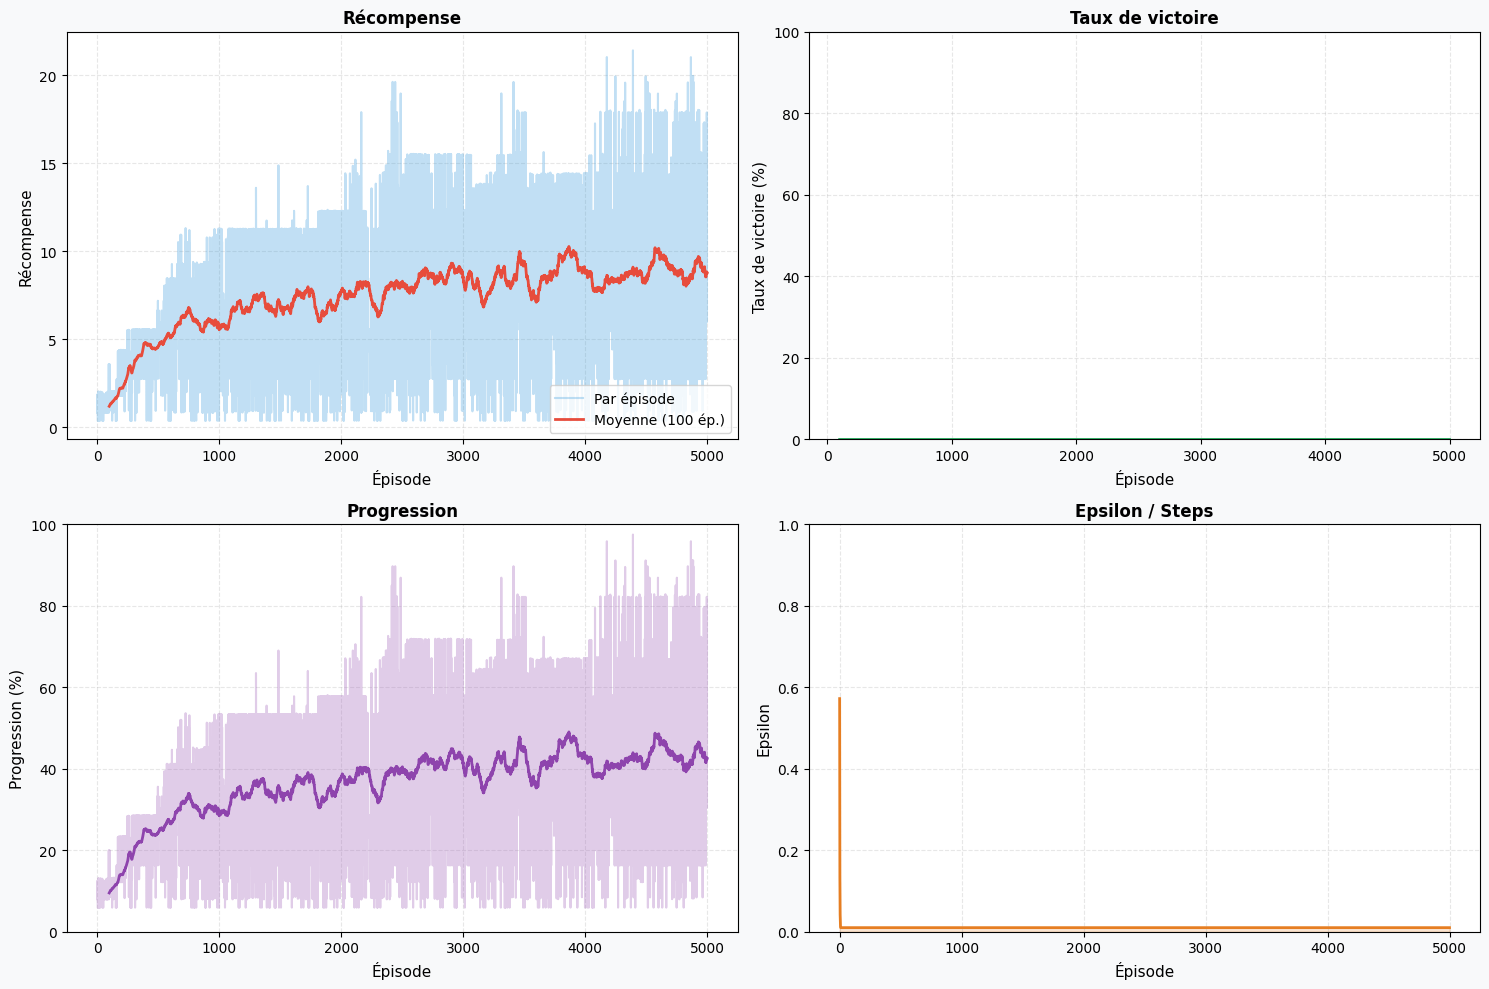

In [8]:
# Visualisation des résultats DQN
dqn_plotter.plot_all(window_size=100, save=True, show=True)

### 4.3 Entraînement de l'agent REINFORCE

Maintenant, entraînons l'agent Policy Gradient avec les mêmes conditions pour une comparaison équitable.

In [9]:
# =============================================================================
# Entraînement de l'agent REINFORCE
# =============================================================================
# Policy Gradient avec baseline pour réduction de variance

# Création d'un nouvel agent REINFORCE avec hyperparamètres optimisés
reinforce_agent = REINFORCEAgent(
    state_size=env.observation_size,
    action_size=2,
    hidden_sizes=[256, 128],       # Architecture plus grande pour capacité
    learning_rate=0.003,           # LR plus élevé (Monte Carlo = moins de mises à jour)
    gamma=0.99,                    # Même discount que DQN
    entropy_coef=0.02,             # Bonus d'entropie pour exploration
    baseline_decay=0.99            # Lissage de la baseline
)

# Même nombre d'épisodes pour comparaison équitable
NUM_EPISODES_REINFORCE = 5000

reinforce_plotter, reinforce_stats = train_agent(
    agent=reinforce_agent,
    env=env,
    num_episodes=NUM_EPISODES_REINFORCE,
    max_steps=5000,
    print_frequency=200,
    agent_name="REINFORCE"
)

# Sauvegarde
reinforce_agent.save("reinforce_trained.pth")

Entraînement de REINFORCE
   Episodes: 5000, Max steps: 5000
Episode   200 | Reward:    1.01 | Win Rate:   0.0% | Progress:   8.8% | Best: 16.3% | 
Episode   400 | Reward:    0.84 | Win Rate:   0.0% | Progress:   8.1% | Best: 16.3% | 
Episode   600 | Reward:    0.83 | Win Rate:   0.0% | Progress:   8.0% | Best: 16.3% | 
Episode   800 | Reward:    0.83 | Win Rate:   0.0% | Progress:   8.0% | Best: 16.3% | 
Episode  1000 | Reward:    0.83 | Win Rate:   0.0% | Progress:   8.0% | Best: 16.3% | 
Episode  1200 | Reward:    0.83 | Win Rate:   0.0% | Progress:   8.0% | Best: 16.3% | 
Episode  1400 | Reward:    0.83 | Win Rate:   0.0% | Progress:   8.0% | Best: 16.3% | 
Episode  1600 | Reward:    0.83 | Win Rate:   0.0% | Progress:   8.0% | Best: 16.3% | 
Episode  1800 | Reward:    0.83 | Win Rate:   0.0% | Progress:   8.0% | Best: 16.3% | 
Episode  2000 | Reward:    0.83 | Win Rate:   0.0% | Progress:   8.0% | Best: 16.3% | 
Episode  2200 | Reward:    0.84 | Win Rate:   0.0% | Progress:   8.1%

Graphique sauvegardé: plots_REINFORCE\training_summary.png


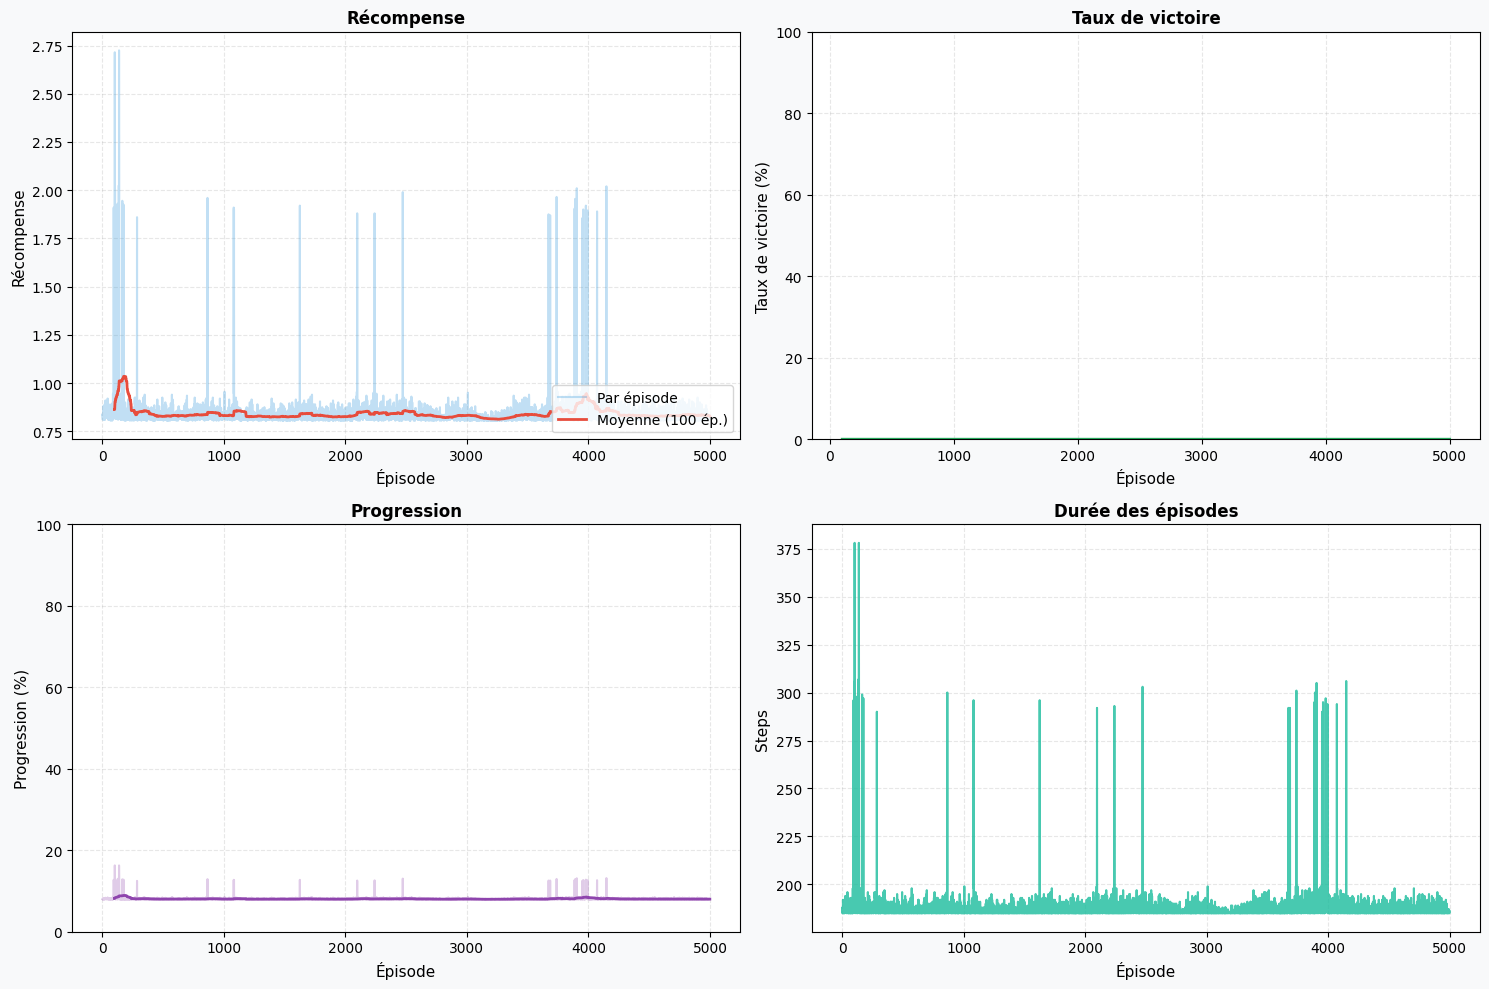

In [10]:
# Visualisation des résultats REINFORCE
reinforce_plotter.plot_all(window_size=100, save=True, show=True)

### 4.4 Résultats approfondis avec les scripts Python

Les résultats présentés ci-dessus proviennent de l'entraînement réalisé directement dans ce notebook. Cependant, nous avons également mené des expériences plus approfondies en utilisant les scripts Python du dossier `Rl_agents/`, permettant des entraînements plus longs (10 000+ épisodes) avec sauvegarde de checkpoints et visualisation des replays.

#### Résumé de l'entraînement DQN (10 000 épisodes)

![Training Summary](Rl_agents/checkpoints_DQN_10000_v3/plots/training_summary.png)


#### Heatmap des sauts de l'agent

![Jump Heatmap](Rl_agents/jump_heatmap_v3.png)

**Analyse du comportement de l'agent :**

Cette heatmap visualise les positions où l'agent décide de sauter. Les zones rouges/jaunes indiquent une haute fréquence de sauts, tandis que les zones bleues montrent peu ou pas de sauts.

- L'agent a appris à **sauter à des positions stratégiques** correspondant aux obstacles (spikes, gaps)
- On observe des **patterns de saut répétitifs** aux mêmes positions X, ce qui indique que l'agent a développé une stratégie cohérente
- Les sauts sont concentrés aux **moments critiques** du niveau, évitant les sauts inutiles qui pourraient mener à des collisions

**Pour visualiser le meilleur replay**, exécutez dans un terminal :
```bash
cd Rl_agents
python main.py --mode watch --replay DQNAgent_best_replay.vis
```

---

## 5. Analyse Comparative des Performances

### 5.1 Évaluation quantitative

Évaluons les deux agents entraînés sur 100 épisodes en mode évaluation (sans exploration).

In [7]:
# =============================================================================
# Évaluation des agents entraînés
# =============================================================================

def evaluate_agent(agent, env: DashGameEnv, num_episodes: int = 100, 
                   agent_name: str = "Agent") -> Dict:
    """
    Évalue un agent sur plusieurs épisodes SANS entraînement.
    
    Args:
        agent: Agent à évaluer
        env: Environnement
        num_episodes: Nombre d'épisodes d'évaluation
        agent_name: Nom pour les logs
        
    Returns:
        Dictionnaire de statistiques
    """
    wins = 0
    total_reward = 0
    total_progress = 0
    all_rewards = []
    all_progress = []
    
    print(f"\nÉvaluation de {agent_name} sur {num_episodes} épisodes...")
    
    for episode in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            # Mode évaluation: pas d'exploration
            action = agent.select_action(obs, training=False)
            obs, reward, done, info = env.step(action)
            episode_reward += reward
        
        total_reward += episode_reward
        total_progress += info['progress']
        all_rewards.append(episode_reward)
        all_progress.append(info['progress'])
        
        if info['won']:
            wins += 1
    
    stats = {
        'win_rate': wins / num_episodes,
        'avg_reward': total_reward / num_episodes,
        'std_reward': np.std(all_rewards),
        'avg_progress': total_progress / num_episodes,
        'std_progress': np.std(all_progress),
        'total_wins': wins,
        'best_progress': max(all_progress)
    }
    
    print(f"   Win Rate: {stats['win_rate']*100:.1f}%")
    print(f"   Avg Reward: {stats['avg_reward']:.2f} ± {stats['std_reward']:.2f}")
    print(f"   Avg Progress: {stats['avg_progress']*100:.1f}% ± {stats['std_progress']*100:.1f}%")
    print(f"   Best Progress: {stats['best_progress']*100:.1f}%")
    
    return stats


# Évaluation des deux agents
print("=" * 70)
print("ÉVALUATION FINALE DES AGENTS")
print("=" * 70)

dqn_eval = evaluate_agent(dqn_agent, env, num_episodes=100, agent_name="DQN")
reinforce_eval = evaluate_agent(reinforce_agent, env, num_episodes=100, agent_name="REINFORCE")

ÉVALUATION FINALE DES AGENTS

Évaluation de DQN sur 100 épisodes...
   Win Rate: 0.0%
   Avg Reward: 1.79 ± 0.00
   Avg Progress: 12.2% ± 0.0%
   Best Progress: 12.2%

Évaluation de REINFORCE sur 100 épisodes...
   Win Rate: 0.0%
   Avg Reward: 0.37 ± 0.00
   Avg Progress: 5.9% ± 0.0%
   Best Progress: 5.9%


C:\Users\durak\AppData\Local\Temp\ipykernel_13292\1000129182.py:50: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max_val * 1.2)


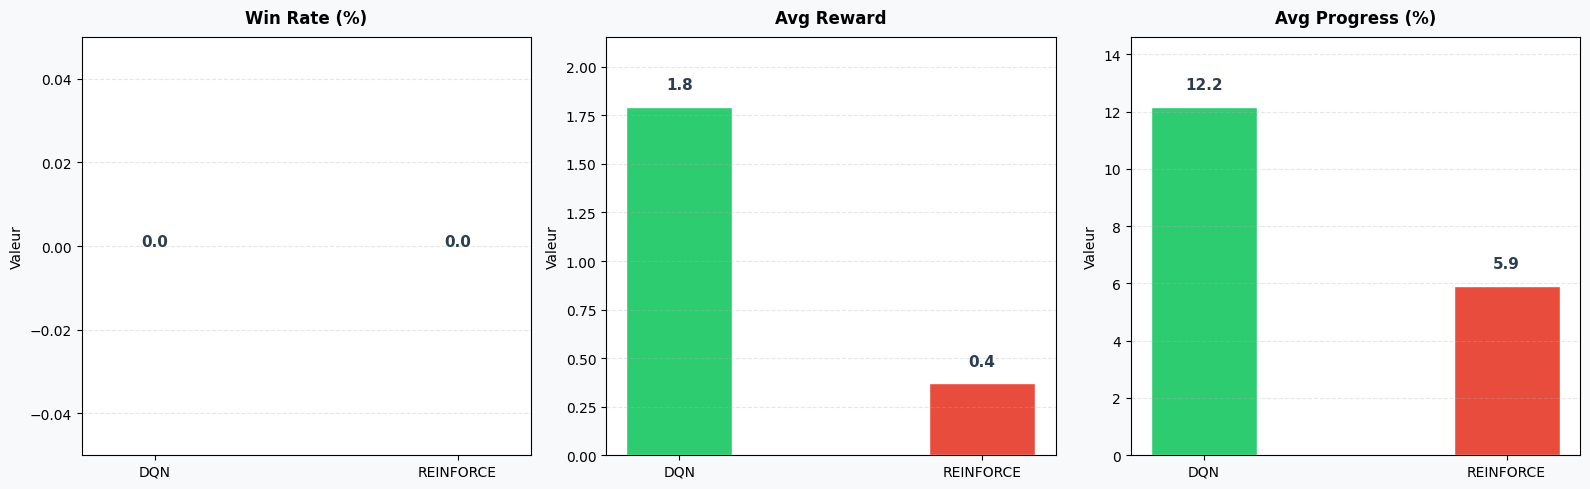


TABLEAU COMPARATIF
Métrique                           DQN       REINFORCE
------------------------------------------------------------
Win Rate (%)                       0.0             0.0
Avg Reward                         1.8             0.4
Avg Progress (%)                  12.2             5.9


In [8]:
# =============================================================================
# 5.2 Visualisation comparative - Barres côte à côte
# =============================================================================

# Création du graphique avec 4 métriques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.patch.set_facecolor('#f8f9fa')

metrics = ['Win Rate (%)', 'Avg Reward', 'Avg Progress (%)', 'Best Progress (%)']
dqn_values = [
    dqn_eval['win_rate'] * 100, 
    dqn_eval['avg_reward'], 
    dqn_eval['avg_progress'] * 100, 
]
reinforce_values = [
    reinforce_eval['win_rate'] * 100, 
    reinforce_eval['avg_reward'],
    reinforce_eval['avg_progress'] * 100, 
]

# Couleurs
color_dqn = '#2ecc71'      # Vert
color_reinforce = '#e74c3c' # Rouge

bar_width = 0.35
x_pos = np.array([0, 1])

for i, (metric, dqn_val, reinforce_val) in enumerate(zip(metrics, dqn_values, reinforce_values)):
    ax = axes[i]
    ax.set_facecolor('#ffffff')
    
    # Barres
    bars1 = ax.bar(0, dqn_val, bar_width, color=color_dqn, label='DQN', edgecolor='white', linewidth=1)
    bars2 = ax.bar(1, reinforce_val, bar_width, color=color_reinforce, label='REINFORCE', edgecolor='white', linewidth=1)
    
    # Valeurs sur les barres
    ax.text(0, dqn_val + max(dqn_val, reinforce_val) * 0.05, f'{dqn_val:.1f}', 
            ha='center', fontsize=11, fontweight='bold', color='#2c3e50')
    ax.text(1, reinforce_val + max(dqn_val, reinforce_val) * 0.05, f'{reinforce_val:.1f}', 
            ha='center', fontsize=11, fontweight='bold', color='#2c3e50')
    
    ax.set_title(metric, fontsize=12, fontweight='bold', pad=10)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['DQN', 'REINFORCE'], fontsize=10)
    ax.set_ylabel('Valeur', fontsize=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Ajuster les limites Y pour éviter l'espace blanc
    max_val = max(dqn_val, reinforce_val)
    ax.set_ylim(0, max_val * 1.2)

plt.tight_layout()
plt.savefig("comparison_bars.png", dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
plt.show()
plt.close()

# Tableau récapitulatif
print("\n" + "=" * 60)
print("TABLEAU COMPARATIF")
print("=" * 60)
print(f"{'Métrique':<22} {'DQN':>15} {'REINFORCE':>15}")
print("-" * 60)
for metric, dqn_val, reinforce_val in zip(metrics, dqn_values, reinforce_values):
    print(f"{metric:<22} {dqn_val:>15.1f} {reinforce_val:>15.1f}")
print("=" * 60)

### 5.3 Analyse des résultats

#### Observations clés

1. **Vitesse de convergence**: DQN tend à apprendre plus rapidement grâce à l'Experience Replay qui permet de réutiliser les expériences passées.

2. **Stabilité**: REINFORCE présente généralement plus de variance dans ses performances car il apprend sur des trajectoires complètes (Monte Carlo) alors que DQN utilise le bootstrapping.

3. **Performance finale**: Les deux approches peuvent atteindre des performances similaires, mais DQN est plus efficace pour les environnements avec des récompenses sparse comme notre jeu.

#### Avantages de chaque approche

| Aspect | DQN | REINFORCE |
|--------|-----|-----------|
| **Sample efficiency** | Meilleure (replay) | Moins bonne |
| **Stabilité** | Target network | Haute variance |
| **Simplicité** | Plus complexe | Plus simple |
| **Mémoire** | Buffer requis | Faible |

---

## 6. Étude de Sensibilité aux Hyperparamètres

Cette section analyse l'impact des principaux hyperparamètres sur les performances des agents.

### 6.1 Hyperparamètres étudiés

Pour **DQN**, nous étudions :
- **Learning Rate** ($\alpha$): Vitesse d'apprentissage
- **Gamma** ($\gamma$): Facteur de discount  
- **Epsilon Decay**: Vitesse de réduction de l'exploration
- **Batch Size**: Taille des mini-batches

Pour **REINFORCE**, nous étudions :
- **Learning Rate** ($\alpha$)
- **Gamma** ($\gamma$)
- **Entropy Coefficient**: Bonus d'exploration

In [9]:
# =============================================================================
# Étude de sensibilité - Learning Rate
# =============================================================================
# Analyse de l'impact du taux d'apprentissage sur les performances

def hyperparameter_study_lr(agent_class, agent_name: str, learning_rates: List[float],
                            num_episodes: int = 500) -> Dict:
    """
    Étudie l'impact du learning rate sur les performances.
    
    Args:
        agent_class: Classe de l'agent (DQNAgent ou REINFORCEAgent)
        agent_name: Nom pour les logs
        learning_rates: Liste des LR à tester
        num_episodes: Nombre d'épisodes par test
        
    Returns:
        Dictionnaire des résultats
    """
    results = {}
    
    print(f"\nÉtude du Learning Rate pour {agent_name}")
    print("=" * 50)
    
    for lr in learning_rates:
        print(f"\nTest avec LR = {lr}")
        
        # Créer un nouvel agent avec ce LR
        if agent_name == "DQN":
            agent = DQNAgent(
                state_size=env.observation_size,
                action_size=2,
                learning_rate=lr,
                hidden_sizes=[256, 128],
                gamma=0.99,
                epsilon_decay=0.997
            )
        else:
            agent = REINFORCEAgent(
                state_size=env.observation_size,
                action_size=2,
                learning_rate=lr,
                hidden_sizes=[128, 64],
                gamma=0.99
            )
        
        # Entraînement rapide
        plotter, stats = train_agent(
            agent=agent,
            env=env,
            num_episodes=num_episodes,
            max_steps=3000,
            print_frequency=num_episodes,  # Afficher seulement à la fin
            agent_name=f"{agent_name}_LR{lr}"
        )
        
        results[lr] = {
            'avg_reward': stats['avg_reward'],
            'win_rate': stats['win_rate'],
            'avg_progress': stats['avg_progress'],
            'history': plotter.progress_history
        }
        
        print(f"   Résultat: Progress = {stats['avg_progress']*100:.1f}%, "
              f"Win Rate = {stats['win_rate']*100:.1f}%")
    
    return results


# Test sur quelques valeurs de learning rate
learning_rates_test = [0.0001, 0.0005, 0.001, 0.005]

print("=" * 70)
print("ÉTUDE DE SENSIBILITÉ - LEARNING RATE")
print("=" * 70)

# Étude pour DQN (version courte pour le rapport)
lr_results_dqn = hyperparameter_study_lr(
    DQNAgent, "DQN", 
    learning_rates=learning_rates_test,
    num_episodes=100
)

ÉTUDE DE SENSIBILITÉ - LEARNING RATE

Étude du Learning Rate pour DQN

Test avec LR = 0.0001
Entraînement de DQN_LR0.0001
   Episodes: 100, Max steps: 3000
Episode   100 | Reward:    1.72 | Win Rate:   0.0% | Progress:  11.9% | Best: 23.6% | ε=0.0100
Entraînement terminé en 115.7s
   Récompense moyenne (100 derniers): 1.72
   Taux de victoire: 0.0%
   Progression moyenne: 11.9%
   Meilleure progression: 23.6%
   Résultat: Progress = 11.9%, Win Rate = 0.0%

Test avec LR = 0.0005
Entraînement de DQN_LR0.0005
   Episodes: 100, Max steps: 3000
Episode   100 | Reward:    1.11 | Win Rate:   0.0% | Progress:   9.2% | Best: 16.3% | ε=0.0100
Entraînement terminé en 84.1s
   Récompense moyenne (100 derniers): 1.11
   Taux de victoire: 0.0%
   Progression moyenne: 9.2%
   Meilleure progression: 16.3%
   Résultat: Progress = 9.2%, Win Rate = 0.0%

Test avec LR = 0.001
Entraînement de DQN_LR0.001
   Episodes: 100, Max steps: 3000
Episode   100 | Reward:    1.40 | Win Rate:   0.0% | Progress:  10.5%

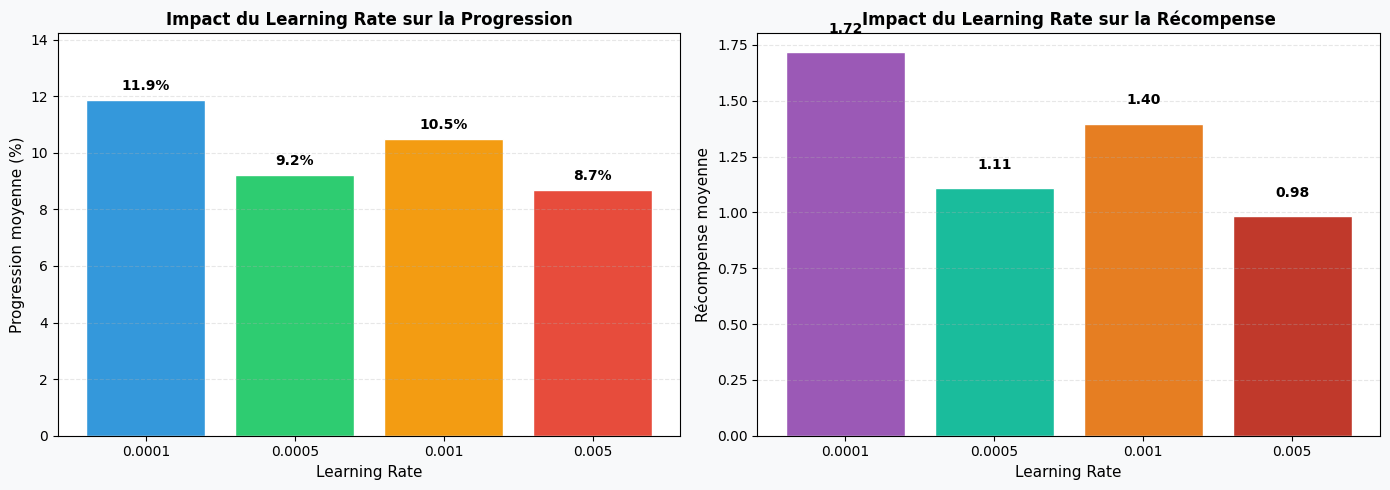


Meilleur Learning Rate pour DQN: 0.0001
   Progression: 11.9%


In [10]:
# =============================================================================
# Visualisation de l'étude Learning Rate
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#f8f9fa')

lrs = list(lr_results_dqn.keys())
progress_values = [lr_results_dqn[lr]['avg_progress'] * 100 for lr in lrs]
reward_values = [lr_results_dqn[lr]['avg_reward'] for lr in lrs]

# Dégradé de couleurs pour les barres
colors_progress = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
colors_reward = ['#9b59b6', '#1abc9c', '#e67e22', '#c0392b']

# 1. Progression vs LR
ax = axes[0]
ax.set_facecolor('#ffffff')
bars1 = ax.bar(range(len(lrs)), progress_values, color=colors_progress, edgecolor='white', linewidth=1)
ax.set_xticks(range(len(lrs)))
ax.set_xticklabels([str(lr) for lr in lrs], fontsize=10)
ax.set_xlabel('Learning Rate', fontsize=11)
ax.set_ylabel('Progression moyenne (%)', fontsize=11)
ax.set_title('Impact du Learning Rate sur la Progression', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--', axis='y')
ax.set_ylim(0, max(progress_values) * 1.2 if progress_values else 100)

for i, v in enumerate(progress_values):
    ax.text(i, v + max(progress_values) * 0.03, f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')

# 2. Récompense vs LR  
ax = axes[1]
ax.set_facecolor('#ffffff')
bars2 = ax.bar(range(len(lrs)), reward_values, color=colors_reward, edgecolor='white', linewidth=1)
ax.set_xticks(range(len(lrs)))
ax.set_xticklabels([str(lr) for lr in lrs], fontsize=10)
ax.set_xlabel('Learning Rate', fontsize=11)
ax.set_ylabel('Récompense moyenne', fontsize=11)
ax.set_title('Impact du Learning Rate sur la Récompense', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--', axis='y')

for i, v in enumerate(reward_values):
    offset = max(reward_values) * 0.05 if reward_values else 0.5
    ax.text(i, v + offset, f'{v:.2f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig("lr_sensitivity.png", dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
plt.show()
plt.close()

# Meilleur LR
best_lr = max(lr_results_dqn.keys(), key=lambda x: lr_results_dqn[x]['avg_progress'])
print(f"\nMeilleur Learning Rate pour DQN: {best_lr}")
print(f"   Progression: {lr_results_dqn[best_lr]['avg_progress']*100:.1f}%")

### 6.2 Impact du Facteur de Discount (Gamma)

Le facteur de discount $\gamma$ contrôle l'importance accordée aux récompenses futures :
- $\gamma \approx 0$ : Focus sur les récompenses immédiates (myope)
- $\gamma \approx 1$ : Planification à long terme

Pour un jeu comme Dash où la victoire n'arrive qu'à la fin, un gamma élevé est essentiel.


Étude du Gamma pour DQN

🔬 Test avec γ = 0.9
Entraînement de DQN_gamma0.9
   Episodes: 100, Max steps: 3000
Episode   100 | Reward:    1.73 | Win Rate:   0.0% | Progress:  11.9% | Best: 23.5% | ε=0.0100
Entraînement terminé en 116.3s
   Récompense moyenne (100 derniers): 1.73
   Taux de victoire: 0.0%
   Progression moyenne: 11.9%
   Meilleure progression: 23.5%
   Résultat: Progress = 11.9%

🔬 Test avec γ = 0.95
Entraînement de DQN_gamma0.95
   Episodes: 100, Max steps: 3000
Episode   100 | Reward:    1.61 | Win Rate:   0.0% | Progress:  11.4% | Best: 23.5% | ε=0.0100
Entraînement terminé en 102.6s
   Récompense moyenne (100 derniers): 1.61
   Taux de victoire: 0.0%
   Progression moyenne: 11.4%
   Meilleure progression: 23.5%
   Résultat: Progress = 11.4%

🔬 Test avec γ = 0.99
Entraînement de DQN_gamma0.99
   Episodes: 100, Max steps: 3000
Episode   100 | Reward:    1.68 | Win Rate:   0.0% | Progress:  11.7% | Best: 23.4% | ε=0.0100
Entraînement terminé en 110.9s
   Récompense moyen

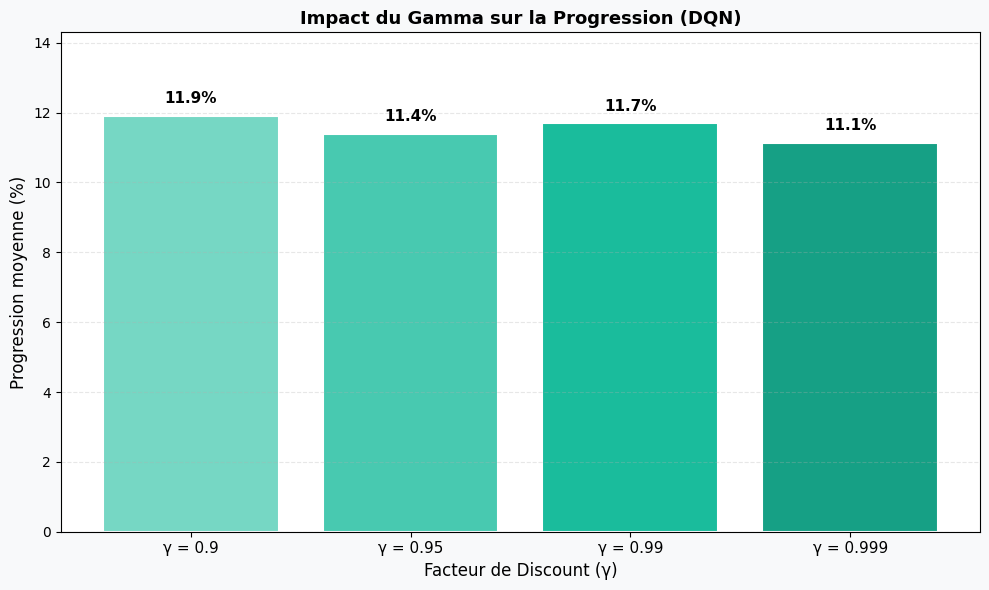


Meilleur Gamma pour DQN: 0.9


In [11]:
# =============================================================================
# Étude de sensibilité - Gamma (Discount Factor)
# =============================================================================

def hyperparameter_study_gamma(agent_class, agent_name: str, gammas: List[float],
                               num_episodes: int = 500) -> Dict:
    """Étudie l'impact du facteur de discount gamma."""
    results = {}
    
    print(f"\nÉtude du Gamma pour {agent_name}")
    print("=" * 50)
    
    for gamma in gammas:
        print(f"\n🔬 Test avec γ = {gamma}")
        
        if agent_name == "DQN":
            agent = DQNAgent(
                state_size=env.observation_size,
                action_size=2,
                learning_rate=0.0005,
                hidden_sizes=[256, 128],
                gamma=gamma,
                epsilon_decay=0.997
            )
        else:
            agent = REINFORCEAgent(
                state_size=env.observation_size,
                action_size=2,
                learning_rate=0.001,
                hidden_sizes=[128, 64],
                gamma=gamma
            )
        
        plotter, stats = train_agent(
            agent=agent,
            env=env,
            num_episodes=num_episodes,
            max_steps=3000,
            print_frequency=num_episodes,
            agent_name=f"{agent_name}_gamma{gamma}"
        )
        
        results[gamma] = {
            'avg_reward': stats['avg_reward'],
            'win_rate': stats['win_rate'],
            'avg_progress': stats['avg_progress']
        }
        
        print(f"   Résultat: Progress = {stats['avg_progress']*100:.1f}%")
    
    return results


# Test sur différentes valeurs de gamma
gammas_test = [0.9, 0.95, 0.99, 0.999]

gamma_results_dqn = hyperparameter_study_gamma(
    DQNAgent, "DQN",
    gammas=gammas_test,
    num_episodes=100
)

# Visualisation améliorée
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#f8f9fa')
ax.set_facecolor('#ffffff')

gammas = list(gamma_results_dqn.keys())
progress_values = [gamma_results_dqn[g]['avg_progress'] * 100 for g in gammas]

# Dégradé de couleurs (du clair au foncé)
colors_gamma = ['#76d7c4', '#48c9b0', '#1abc9c', '#16a085']

bars = ax.bar(range(len(gammas)), progress_values, color=colors_gamma, edgecolor='white', linewidth=1.5)
ax.set_xticks(range(len(gammas)))
ax.set_xticklabels([f'γ = {g}' for g in gammas], fontsize=11)
ax.set_xlabel('Facteur de Discount (γ)', fontsize=12)
ax.set_ylabel('Progression moyenne (%)', fontsize=12)
ax.set_title('Impact du Gamma sur la Progression (DQN)', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--', axis='y')
ax.set_ylim(0, max(progress_values) * 1.2 if progress_values else 100)

for i, v in enumerate(progress_values):
    ax.text(i, v + max(progress_values) * 0.03, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("gamma_sensitivity.png", dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
plt.show()
plt.close()

best_gamma = max(gamma_results_dqn.keys(), key=lambda x: gamma_results_dqn[x]['avg_progress'])
print(f"\nMeilleur Gamma pour DQN: {best_gamma}")

### 6.3 Impact de la Décroissance d'Epsilon (DQN)

La décroissance d'epsilon contrôle la transition entre exploration et exploitation :
- Décroissance rapide : Exploitation précoce, risque de convergence vers un optimum local
- Décroissance lente : Plus d'exploration, convergence plus lente mais potentiellement meilleure


Étude de la Décroissance d'Epsilon pour DQN

🔬 Test avec ε_decay = 0.99
Entraînement de DQN_eps0.99
   Episodes: 100, Max steps: 3000
Episode   100 | Reward:    2.27 | Win Rate:   0.0% | Progress:  14.3% | Best: 30.4% | ε=0.0099
Entraînement terminé en 133.6s
   Récompense moyenne (100 derniers): 2.27
   Taux de victoire: 0.0%
   Progression moyenne: 14.3%
   Meilleure progression: 30.4%
   Résultat: Progress = 14.3%, ε final = 0.0099

🔬 Test avec ε_decay = 0.995
Entraînement de DQN_eps0.995
   Episodes: 100, Max steps: 3000
Episode   100 | Reward:    1.73 | Win Rate:   0.0% | Progress:  11.9% | Best: 30.4% | ε=0.0100
Entraînement terminé en 109.1s
   Récompense moyenne (100 derniers): 1.73
   Taux de victoire: 0.0%
   Progression moyenne: 11.9%
   Meilleure progression: 30.4%
   Résultat: Progress = 11.9%, ε final = 0.0100

🔬 Test avec ε_decay = 0.997
Entraînement de DQN_eps0.997
   Episodes: 100, Max steps: 3000
Episode   100 | Reward:    1.67 | Win Rate:   0.0% | Progress:  11.7% |

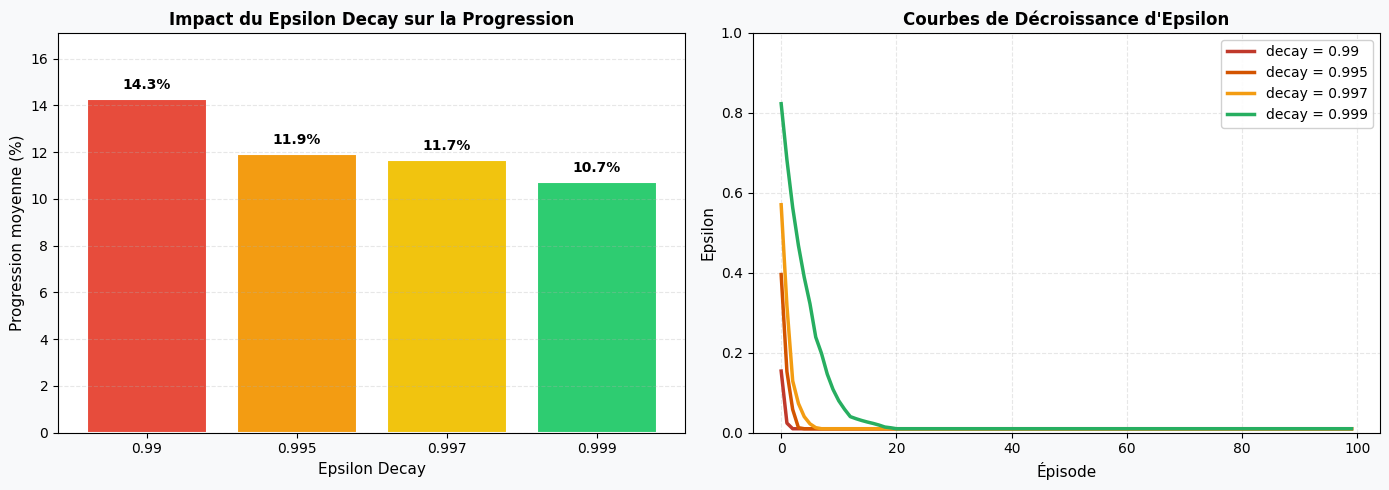


Meilleur Epsilon Decay: 0.99


In [12]:
# =============================================================================
# Étude de sensibilité - Epsilon Decay
# =============================================================================

def hyperparameter_study_epsilon(epsilon_decays: List[float], 
                                  num_episodes: int = 500) -> Dict:
    """Étudie l'impact de la décroissance d'epsilon."""
    results = {}
    
    print(f"\nÉtude de la Décroissance d'Epsilon pour DQN")
    print("=" * 50)
    
    for decay in epsilon_decays:
        print(f"\n🔬 Test avec ε_decay = {decay}")
        
        agent = DQNAgent(
            state_size=env.observation_size,
            action_size=2,
            learning_rate=0.0005,
            hidden_sizes=[256, 128],
            gamma=0.99,
            epsilon_start=1.0,
            epsilon_end=0.01,
            epsilon_decay=decay
        )
        
        plotter, stats = train_agent(
            agent=agent,
            env=env,
            num_episodes=num_episodes,
            max_steps=3000,
            print_frequency=num_episodes,
            agent_name=f"DQN_eps{decay}"
        )
        
        results[decay] = {
            'avg_reward': stats['avg_reward'],
            'win_rate': stats['win_rate'],
            'avg_progress': stats['avg_progress'],
            'epsilon_history': plotter.epsilon_history
        }
        
        print(f"   Résultat: Progress = {stats['avg_progress']*100:.1f}%, ε final = {agent.epsilon:.4f}")
    
    return results


# Test différentes vitesses de décroissance
epsilon_decays = [0.99, 0.995, 0.997, 0.999]

epsilon_results = hyperparameter_study_epsilon(epsilon_decays, num_episodes=100)

# Visualisation améliorée
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#f8f9fa')

decays = list(epsilon_results.keys())
progress_values = [epsilon_results[d]['avg_progress'] * 100 for d in decays]

# Couleurs dégradées
colors_eps = ['#e74c3c', '#f39c12', '#f1c40f', '#2ecc71']
line_colors = ['#c0392b', '#d35400', '#f39c12', '#27ae60']

# 1. Progression vs Epsilon Decay
ax = axes[0]
ax.set_facecolor('#ffffff')
bars = ax.bar(range(len(decays)), progress_values, color=colors_eps, edgecolor='white', linewidth=1.5)
ax.set_xticks(range(len(decays)))
ax.set_xticklabels([str(d) for d in decays], fontsize=10)
ax.set_xlabel('Epsilon Decay', fontsize=11)
ax.set_ylabel('Progression moyenne (%)', fontsize=11)
ax.set_title('Impact du Epsilon Decay sur la Progression', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--', axis='y')
ax.set_ylim(0, max(progress_values) * 1.2 if progress_values else 100)

for i, v in enumerate(progress_values):
    ax.text(i, v + max(progress_values) * 0.03, f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')

# 2. Courbes de décroissance d'epsilon
ax = axes[1]
ax.set_facecolor('#ffffff')
for i, decay in enumerate(decays):
    if epsilon_results[decay]['epsilon_history']:
        ax.plot(epsilon_results[decay]['epsilon_history'], 
                label=f'decay = {decay}', linewidth=2.5, color=line_colors[i])

ax.set_xlabel('Épisode', fontsize=11)
ax.set_ylabel('Epsilon', fontsize=11)
ax.set_title('Courbes de Décroissance d\'Epsilon', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.grid(alpha=0.3, linestyle='--')
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig("epsilon_sensitivity.png", dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
plt.show()
plt.close()

best_decay = max(epsilon_results.keys(), key=lambda x: epsilon_results[x]['avg_progress'])
print(f"\nMeilleur Epsilon Decay: {best_decay}")

---

## 7. Conclusion

### 7.1 Résumé des contributions

Ce projet a permis d'explorer et de comparer deux approches fondamentales du Reinforcement Learning :

1. **Agent DQN (Value-Based)**
   - Utilise un réseau de neurones pour approximer la fonction Q
   - Stabilisé par Experience Replay et Target Network
   - Bon équilibre exploration/exploitation via ε-greedy

2. **Agent REINFORCE (Policy Gradient)**
   - Apprend directement une politique stochastique
   - Réduction de variance via baseline
   - Exploration naturelle par échantillonnage

### 7.2 Leçons apprises

- **Reward Shaping** : Une fonction de récompense bien conçue est cruciale pour guider l'apprentissage
- **Hyperparamètres** : Le learning rate et gamma ont un impact majeur sur les performances
- **Architecture** : Une architecture de réseau adaptée à la complexité du problème est importante
- **Stabilité** : Les techniques comme Target Network et gradient clipping sont essentielles